In [9]:
import sys
from pathlib import Path

from miniai.activations import set_seed
from miniai.datasets import show_image
from miniai.learner import *

from fastai.vision.all import L,imagenet_stats,create_body,resnet34

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import HTML
import cv2

import torch
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
#from torch.utils.data.dataloader import default_collate
import torch.nn.functional as F

from torchvision import transforms as tfms
from torchvision.datasets import CocoDetection

from imgaug.augmentables.bbs import BoundingBoxesOnImage
from imgaug import augmenters as iaa 

IN_COLAB = 'google.colab' in sys.modules

device = torch.device('cuda',0) if torch.cuda.is_available() else torch.device('cpu')
set_seed(6789, deterministic=False)

SIZE = 224  # size of images we'll us

In [3]:
data_path = "./coco_2017" # Path to where you want to store the data
INFERENCE_ONLY = False # Set to True to skip downloading training data
def download_coco():
    print('Coco Download Started.')
    !mkdir -p {data_path}
    !curl "http://images.cocodataset.org/annotations/annotations_trainval2017.zip" > {data_path}/annotations_trainval2017.zip
    !unzip -q -o {data_path}/annotations_trainval2017.zip -d {data_path}
    !rm {data_path}/annotations_trainval2017.zip
    !curl "http://images.cocodataset.org/zips/val2017.zip" > {data_path}/val2017.zip
    !unzip -q -o {data_path}/val2017.zip -d {data_path}
    !rm {data_path}/val2017.zip
    if not INFERENCE_ONLY:
        !curl "http://images.cocodataset.org/zips/train2017.zip" > {data_path}/train2017.zip
        !unzip -q -o {data_path}/train2017.zip -d {data_path}
        !rm {data_path}/train2017.zip
    else: print('Warning: Inference Only Skipping download of training dataset')
    print('Coco Download Completed.')

download_coco()

Coco Download Started.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241M  100  241M    0     0  5888k      0  0:00:41  0:00:41 --:--:-- 5849k   0  0:00:49  0:00:04  0:00:45 5032k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  777M  100  777M    0     0  4608k      0  0:02:52  0:02:52  0:00:01 6095k2:36  0:00:22 5979k:02:52 --:--:-- 5932k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.0G  100 18.0G    0     0  4763k      0  1:06:04  1:06:04 --:--:-- 6051k5:06:26 1750k 4616k      0  1:08:10  0:00:40  1:07:30 5934k21 4157k4561k      0  1:08:59  0:05:33  1:03:26 4171k   0  1:07:54  0:05:47  1:02:07 6364k52M    0     0  4697k      0  1:06:59  0:

In [4]:
colors = [None, (39, 129, 113), (164, 80, 133), (83, 122, 114), (99, 81, 172), (95, 56, 104), (37, 84, 86),
          (14, 89, 122),
          (80, 7, 65), (10, 102, 25), (90, 185, 109), (106, 110, 132), (169, 158, 85), (188, 185, 26), (103, 1, 17),
          (82, 144, 81), (92, 7, 184), (49, 81, 155), (179, 177, 69), (93, 187, 158), (13, 39, 73), (12, 50, 60),
          (16, 179, 33), (112, 69, 165), (15, 139, 63), (33, 191, 159), (182, 173, 32), (34, 113, 133), (90, 135, 34),
          (53, 34, 86), (141, 35, 190), (6, 171, 8), (118, 76, 112), (89, 60, 55), (15, 54, 88), (112, 75, 181),
          (42, 147, 38), (138, 52, 63), (128, 65, 149), (106, 103, 24), (168, 33, 45), (28, 136, 135), (86, 91, 108),
          (52, 11, 76), (142, 6, 189), (57, 81, 168), (55, 19, 148), (182, 101, 89), (44, 65, 179), (1, 33, 26),
          (122, 164, 26), (70, 63, 134), (137, 106, 82), (120, 118, 52), (129, 74, 42), (182, 147, 112), (22, 157, 50),
          (56, 50, 20), (2, 22, 177), (156, 100, 106), (21, 35, 42), (13, 8, 121), (142, 92, 28), (45, 118, 33),
          (105, 118, 30), (7, 185, 124), (46, 34, 146), (105, 184, 169), (22, 18, 5), (147, 71, 73), (181, 64, 91),
          (31, 39, 184), (164, 179, 33), (96, 50, 18), (95, 15, 106), (113, 68, 54), (136, 116, 112), (119, 139, 130),
          (31, 139, 34), (66, 6, 127), (62, 39, 2), (49, 99, 180), (49, 119, 155), (153, 50, 183), (125, 38, 3),
          (129, 87, 143), (49, 87, 40), (128, 62, 120), (73, 85, 148), (28, 144, 118), (29, 9, 24), (175, 45, 108),
          (81, 175, 64), (178, 19, 157), (74, 188, 190), (18, 114, 2), (62, 128, 96), (21, 3, 150), (0, 6, 95),
          (2, 20, 184), (122, 37, 185)]

vocab = ["bg", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
                "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog",
                "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
                "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
                "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
                "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
                "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant",
                "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone",
                "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
                "teddy bear", "hair drier", "toothbrush"]

cat2id = {v:k for k,v in enumerate(vocab)}
id2cat = {k:v for k,v in enumerate(vocab)}

print(f'The number of classes in the dataset: {len(vocab)}')

The number of classes in the dataset: 81


In [15]:
xmean,xstd = L(imagenet_stats).map(tensor)

In [17]:
xmean, xstd

(tensor([0.4850, 0.4560, 0.4060]), tensor([0.2290, 0.2240, 0.2250]))

In [18]:
num_workers = 4
batch_size = 16
num_gpus = 1

In [19]:
from torch.utils.data import DataLoader, default_collate

In [22]:
ex_t = torch.zeros(5,4)

In [25]:
t_ = torch.zeros(1,4)
torch.cat([t_,ex_t],dim=0).shape

torch.Size([6, 4])

In [26]:
def pad_bb_tensor(t, m):
    return torch.cat([t, torch.zeros(m - len(t), 4)], dim=0)

def pad_cl_tensor(t, m):
    return torch.cat([t, torch.zeros(m - len(t))], dim=0).long()

# We need to zero-pad the boxes and labels to the max number of boxes in a batch
def collate_fn(batch):
    items = list(zip(*batch))
    
    m = 0
    for i in items[1]:
        if i is None:
            continue
        l = len(i) 
        if l > m: m = l

    items[0] = default_collate([i for i in items[0] if torch.is_tensor(i)])
    boxes = [pad_bb_tensor(i,m) for i in items[1] if torch.is_tensor(i)]
    clses = [pad_cl_tensor(i,m) for i in items[2] if torch.is_tensor(i)]

    items[1] = default_collate(boxes)
    items[2] = default_collate(clses)

    return items

In [27]:
train_params = {"batch_size": batch_size * num_gpus,
                "shuffle": True,
                "drop_last": False,
                "num_workers": num_workers,
                "collate_fn": collate_fn
                }

In [28]:
valid_params = {"batch_size": batch_size * num_gpus,
                "shuffle": False,
                "drop_last": False,
                "num_workers": num_workers,
                "collate_fn": collate_fn
                }

In [33]:

class CocoDataset(CocoDetection):
    def __init__(
                 self, 
                 root, 
                 year, 
                 mode, 
                 transform=None):
        root = Path(root)
        annFile = root/f"annotations/instances_{mode}{year}.json"
        root = root/f"{mode}{year}"
        super(CocoDataset, self).__init__(root, annFile)
        self._load_categories()
        self.transform = transform

    def _load_categories(self):
        categories = self.coco.loadCats(self.coco.getCatIds())
        categories.sort(key=lambda x: x["id"])

        self.label_map = {}
        self.label_info = {}
        counter = 1
        self.label_info[0] = "background"
        for c in categories:
            self.label_map[c["id"]] = counter
            self.label_info[counter] = c["name"]
            counter += 1

    def __getitem__(self, item):
        image, target = super(CocoDataset, self).__getitem__(item)
        width, height = image.size
        boxes = []
        labels = []
        if len(target) == 0:
            return None, None, None, None, None
        for annotation in target:
            bbox = annotation.get("bbox")
            boxes.append([bbox[0], bbox[1], (bbox[0] + bbox[2]), (bbox[1] + bbox[3])])
            labels.append(self.label_map[annotation.get("category_id")])
        if self.transform is not None:
            image, (height, width), boxes, labels = self.transform(image, (height, width), boxes, labels)
        return image, torch.tensor(boxes), torch.tensor(labels).long()

In [36]:
# denormalize the image data based on imagenet stats
def denormalize(x):
    return x*xstd[...,None,None]+xmean[...,None,None]

# scale and center the image data based on imagenet stats
def normalize(x):
    return (x-xmean[:,None,None])/xstd[:,None,None]
    
class Xfm(object):
    def __init__(self,size,augment=True):
        self.augment = augment
        self.size = size
        self.tseq = iaa.Sequential([
            iaa.Resize({"height": size[0], "width": size[1]}),
            iaa.Fliplr(0.5),
            iaa.Flipud(0.20),
            iaa.GammaContrast(1.5),
            iaa.Sometimes(
                0.5,iaa.Sequential([iaa.Affine(translate_percent={"x": (-0.15,0.15),"y": (-0.15,0.15)},rotate=(5,-5), scale=(0.15, 1.5)),
                iaa.CoarseDropout(0.1, per_channel=True)    
            ]))
        ])
        self.vseq = iaa.Sequential([
            iaa.Resize({"height": size[0], "width": size[1]})
        ])

    def __call__(
                self,
                img,
                _img_size,
                bboxes=None,
                labels=None
                ):
        img = np.array(img)
        bbs = BoundingBoxesOnImage.from_xyxy_array(bboxes, shape=img.shape)

        if (self.augment): 
            n = len(list(bbs.bounding_boxes))

            im_aug,bbs_aug = self.tseq(image=img, bounding_boxes=bbs)

            bbs_aug = bbs_aug.clip_out_of_image()
            n2 = len(list(bbs_aug.bounding_boxes))         
            if n != n2: # at least one bounding box is fully outside of the image boundary
                # bail out of augmentation for this sample
                #print('bailing out of augmentation for this sample')
                im_aug,bbs_aug = self.vseq(image=img, bounding_boxes=bbs)
        else: im_aug,bbs_aug = self.vseq(image=img, bounding_boxes=bbs)

        b = (bbs_aug.to_xyxy_array()/(self.size[0]/2))-1  # scale the bounding boxes to be between -1 and 1

        img = normalize(tfms.ToTensor()(im_aug)) # normalize the image data with imagenet stats

        return img,self.size,b,labels

In [42]:
 train_set = CocoDataset(data_path,2017,"train",Xfm((SIZE,SIZE),True))
 train_dl = DataLoader(train_set, **train_params)

loading annotations into memory...
Done (t=16.26s)
creating index...
index created!


In [45]:

 val_set = CocoDataset(data_path,2017,"val",Xfm((SIZE,SIZE),False))
 val_dl = DataLoader(val_set, **valid_params)

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


In [46]:
# takes an image tensor; denormalizes it and scales it up so that we have enough pixels to render our annotations reasonably
def denormalize_tensor(im_tensor):
    im = denormalize(im_tensor)
    im = (im - im.min()/(im.max()-im.min())).clip(0,1)
    im = np.array(im.permute(1,2,0)*255).astype(np.uint8).copy()
    im = cv2.resize(im, (768,768))
    return im

In [47]:
def showobjects(im,bbox,clas):
    annotated_im = np.copy(im)

    # composite annotations onto image
    h,w = annotated_im.shape[:2]
    # for each non-background class label
    for i in range(len(clas)):
        if clas[i] == 0: continue # skip background
        category=id2cat[clas[i].item()]
        color = colors[clas[i]]

        box = (bbox[i]+1)/2
        x1,y1,x2,y2 = box.tolist()
        x1 = int(x1*w)
        x2 = int(x2*w)
        y1 = int(y1*h)
        y2 = int(y2*h)

        # draw bounding box
        cv2.rectangle(annotated_im,(x1,y1),(x2,y2),color,2)

        # draw category label
        text_size = cv2.getTextSize(category, cv2.FONT_HERSHEY_PLAIN, 1.5, 1)[0]
        cv2.rectangle(annotated_im, (x1, y1), (x1 + text_size[0] + 3, y1 + text_size[1] + 4), color,
                        -1)
        cv2.putText(annotated_im, category,
            (x1, y1 + text_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1.5,
            (255, 255, 255), 1)   
    return annotated_im


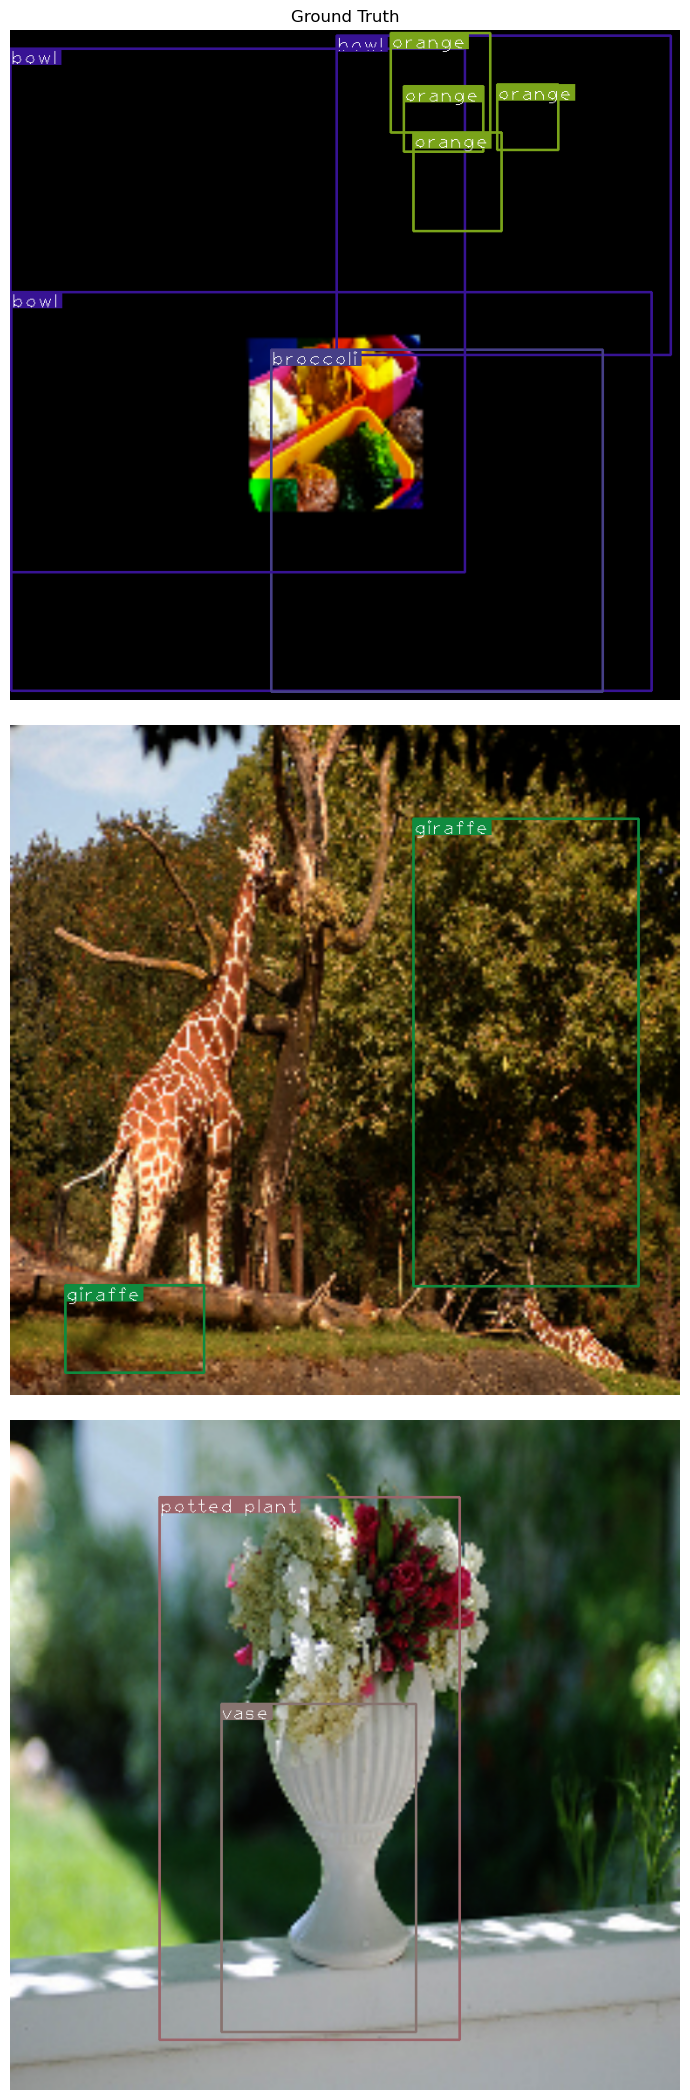

In [70]:

num_to_show = 3
fig,ax = plt.subplots(num_to_show,1,figsize=(7,7*num_to_show))
for i in range(num_to_show):
    show_image(showobjects(denormalize_tensor(train_set[i][0]),train_set[i][1],train_set[i][2]),ax=ax[i])
fig.tight_layout()
_ = ax[0].set_title('Ground Truth')

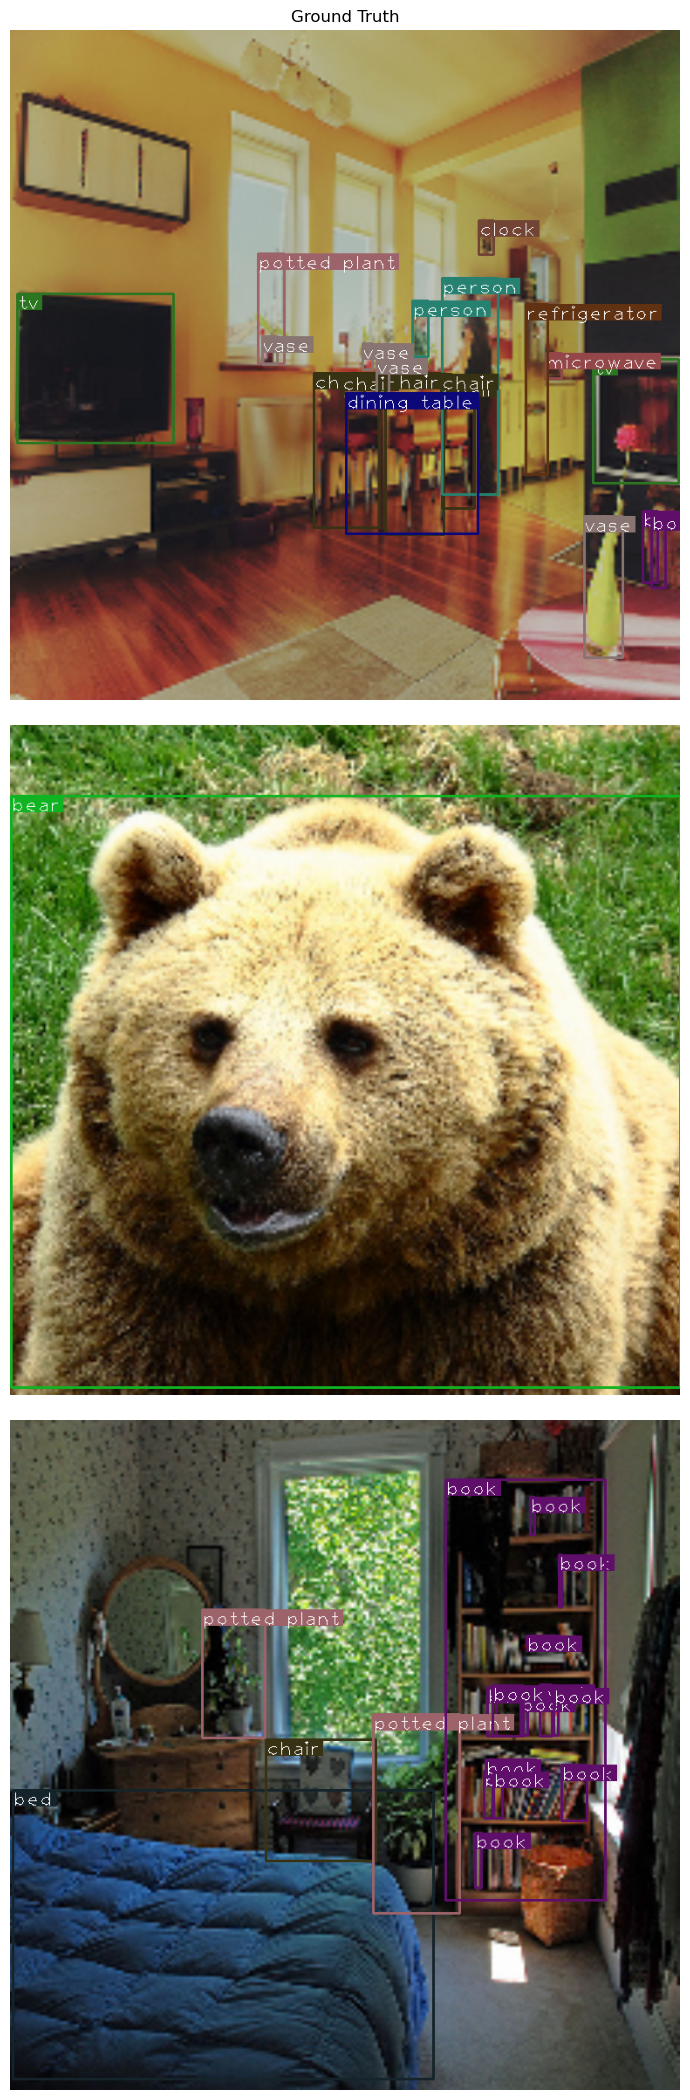

In [57]:
num_to_show = 3
fig,ax = plt.subplots(num_to_show,1,figsize=(7,7*num_to_show))
for i in range(num_to_show):
    show_image(showobjects(denormalize_tensor(val_set[i][0]),val_set[i][1],val_set[i][2]),ax=ax[i])
fig.tight_layout()
_ = ax[0].set_title('Ground Truth')

# Function to convert corners to bounding box and bouding box to corners	

In [71]:
def hw2corn(cntr:int,hw:int)->torch.Tensor:
    return torch.cat([cntr-hw/2,cntr+hw/2],dim=1)


def corn2hw(y1, y2)->torch.Tensor:
    return torch.cat([y1+y2/2, y2-y1], dim=1)

# model

In [72]:
create_body?

Signature: create_body(model, n_in=3, pretrained=True, cut=None)
Docstring: Cut off the body of a typically pretrained `arch` as determined by `cut`
File:      ~/mambaforge/lib/python3.10/site-packages/fastai/vision/learner.py
Type:      function

In [75]:
body = create_body(resnet34(True))
x, *_ = next(iter(train_dl))
x.shape

/home/hasan/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/hasan/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([16, 3, 224, 224])

In [76]:
body(x).shape

torch.Size([16, 512, 7, 7])

- our last layer is currently 7x7  shape
- we will create some other feature map with `4x4`, `2x2`, `1x1`

In [77]:
class ConvLayer(nn.Module):
    def __init__(
                self,
                n_inp:int,
                n_out:int,
                stride:int=2,
                drop:float=0.1):

        super().__init__()
        self.conv = nn.Conv2d(
                             n_inp, 
                             n_out, 
                             kernel_size=3, 
                             stride=stride, 
                             padding=1)

        self.bn = nn.BatchNorm2d(n_out)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        return self.drop(F.relu(self.bn(self.conv(x))))


In [112]:
def flat_conv(
    x:torch.Tensor, 
    k:int, # feature map scaled with this factor
    )->torch.Tensor:
    

    bs, n_f, h, w = x.size()
    x = x.permute(0,2,3,1).contiguous() # [bs, n_f, h, w] -> [bs, h, w, n_f]
    return x.view(bs, -1, n_f//k)

In [106]:
class OutConv(nn.Module):
    def __init__(
                self, 
                k:int, # feature map scaled with this factor
                n_inp:int, 
                bias:int):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(n_inp, (len(vocab)*k), kernel_size=3, padding=1)
        self.oconv2 = nn.Conv2d(n_inp, (4*k), kernel_size=3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)

    def forward(self, x):
        return [flat_conv(self.oconv1(x), self.k), flat_conv(self.oconv2(x), self.k)]

In [107]:
# Function to create a pattern of 45 overlapping anchor boxes in unit coordinates
# and allow for scaling and translation
def mk_unit_anchors(scale,x,y,half=True):
    a = []
    # xyxy format!!
    
    l3 = 1.0
    n3 = l3 * 0.33334
    s3 = -n3
    e3 = 1.+n3-l3

    l5 = 0.5
    n5 = l5 * 0.33334
    s5 = -n5
    e5 = 1.+n5-l5

    # will create 9 square anchor boxes tiled in an overlapping 3x3 grid
    xs = np.linspace(s3,e3,3)
    ys = np.linspace(s3,e3,3)
    a.extend([[y,x,y+l3,x+l3] for y in ys for x in xs])

    if half:
        # will create 18 rectangular boxes tiled in an overlapping 3x6 grid
        # aspect ratio is 1:0.5
        xs = np.linspace(s3,e3,3)
        ys = np.linspace(s5,e5,6)
        a.extend([[x,y,x+l3,y+l5] for y in ys for x in xs])

        # will create 18 rectangular boxes tiled in an overlapping 6x3 grid
        # aspect ratio is 0.5:1
        xs = np.linspace(s5,e5,6)
        ys = np.linspace(s3,e3,3)
        a.extend([[x,y,x+l5,y+l3] for y in ys for x in xs])

    return torch.clamp(tensor(a)*scale+tensor([x,y,x,y]),min=0,max=1)

-Using the functions above, we'll create a set of anchor boxes for each feature map and for each feature map location.

In [108]:
# if image space is defined as 0.-1., then the following are the anchor box scales
# for each feature map layer
s7 = 0.125
s4 = 0.25
s2 = 0.5
s1 = 1.0

a7 = len(mk_unit_anchors(s7,0,0))
a4 = len(mk_unit_anchors(s4,0,0))
a2 = len(mk_unit_anchors(s2,0,0))
a1 = len(mk_unit_anchors(s1,0,0))

anchors_per_map_location = [a7,a4,a2,a1]

# for each feature map 'location' create a set of anchor boxes (45)
anchor_cnr = torch.cat([
    torch.cat([mk_unit_anchors(s7,i*s7,j*s7) for i in range(7) for j in range(7)]),     # for 7x7x45
    torch.cat([mk_unit_anchors(s4,i*s4,j*s4) for i in range(4) for j in range(4)]),     # for 4x4x45
    torch.cat([mk_unit_anchors(s2,i*s2,j*s2) for i in range(2) for j in range(2)]),     # for 2x2x45
    mk_unit_anchors(s1,0,0) # for 1x1x45
    ]).to(device)

anchors = corn2hw(anchor_cnr[:,:2], anchor_cnr[:,2:]).to(device)

print('The total number of anchor boxes is: ',len(anchors))

The total number of anchor boxes is:  3150


In [109]:
class SSD_Multihead(
                    nn.Module):

    def __init__(
                self,
                bias=-4,
                printit=False,
                drop=0
                ):
        super().__init__()
        self.drop = nn.Dropout(drop)
        


        self.sconv0 = ConvLayer(
                               512,
                               256,
                               stride=1, 
                               drop=drop) # 7x7
    
        self.sconv1 = ConvLayer(
                               256,
                               256,
                               drop=drop) # 4x4 

        self.sconv2 = ConvLayer(
                               256,
                               256,
                               drop=drop) # 2x2 
                               
        self.sconv3 = ConvLayer(
                               256,
                               256,
                               drop=drop) # 1x1

        self.out0 = OutConv(a7, 256, bias)
        self.out1 = OutConv(a4, 256, bias)
        self.out2 = OutConv(a2, 256, bias)
        self.out3 = OutConv(a1, 256, bias)
        self.printit = printit


    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        if self.printit: print('sconv0:', x.shape)
        o0c,o0l = self.out0(x)
        if self.printit: print('out0:', o0l.shape)
        x = self.sconv1(x)
        if self.printit: print('sconv1:', x.shape)
        o1c,o1l = self.out1(x)
        if self.printit: print('out1:', o1l.shape)
        x = self.sconv2(x)
        if self.printit: print('sconv2:', x.shape)
        o2c,o2l = self.out2(x)
        if self.printit: print('out2:', o2l.shape)
        x = self.sconv3(x)
        if self.printit: print('sconv3:', x.shape)
        o3c,o3l = self.out3(x)
        if self.printit: print('out3:', o3l.shape)
        return [torch.cat([o0c,o1c,o2c,o3c], dim=1), # 7x7, 4x4, 2x2, 1x1
                torch.cat([o0l,o1l,o2l,o3l], dim=1)] # 7x7, 4x4, 2x2, 1x1

In [110]:
head_reg4 = SSD_Multihead(printit=True) # create an instance of custom head as described above
body = create_body(resnet34(True))  # create a resnet34 model with pretrained weights (downloaded) using fastai's create_body function
model = nn.Sequential(body,head_reg4) # combine the body and the head into a single model

/home/hasan/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/hasan/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [113]:
pred_class, pred_box = model(x)

sconv0: torch.Size([16, 256, 7, 7])
out0: torch.Size([16, 2205, 4])
sconv1: torch.Size([16, 256, 4, 4])
out1: torch.Size([16, 720, 4])
sconv2: torch.Size([16, 256, 2, 2])
out2: torch.Size([16, 180, 4])
sconv3: torch.Size([16, 256, 1, 1])
out3: torch.Size([16, 45, 4])


# loss function